In [11]:
#ЗАВДАННЯ №1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import random

import re

In [103]:
#зчитаємо датасет, очистимо його від зайвих символів, підрахуємо сумарну кількість символів та кількість унікальних 
with open('D:\KPI Styding\DataAnalysis\Lisova_pisnya.txt', encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ").replace("\t", " ").replace("  ", " ") 

words_to_remove = ["т о й, щ о  г р е б л і р в е","л е в"
                   "в о д я н и к", "р у с а л к а",
                   "п о т е р ч а т а","л у к а ш",
                   "л у к а ш","л і с о в и к",
                   "м а в к а","п е р е л е с н и к"]
pattern = "|".join(re.escape(word) for word in words_to_remove)
text = re.sub(pattern, "", text)
text = re.sub(r'\s+', ' ', cleaned_text)
print(cleaned_text[:1000])
chars = sorted(list(set(text)))

старезний, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з великим прастарим дубом. галява скраю переходить в куп'я та очерети, а в одному місці в яро-зелену драговину - то береги лісового озера, що утворилося з лісового струмка. струмок той вибігає з гущавини лісу, впадає в озеро, потім, по другім боці озера, знов витікає і губиться в хащах. саме озеро - тиховоде, вкрите ряскою та лататтям, але з чистим плесом посередині. містина вся дика, таємнича, але не понура, - повна ніжної, задумливої поліської краси. провесна. по узліссі і на галяві зеленіє перший ряст і цвітуть проліски та сон-трава. дерева ще безлисті, але вкриті бростю, що от-от має розкритись. на озері туман то лежить пеленою, то хвилює од вітру, то розривається, одкриваючи блідо-блакитну воду. в лісі щось загомоніло, струмок зашумував, забринів, і вкупі з його водами з лісу вибіг "той, що греблі рве" - молодий, дуже білявий, синьоокий, з буйними і разом плавкими рухами; одежа на йому

In [82]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for c, c in enumerate(chars))

In [104]:
chars = sorted(list(set(text)))
n_chars = len(text)
n_vocab = len(chars)
print("Total chars: ", n_chars)
print("Number unic chars: ", n_vocab)
print("Unic chars: ", chars)

Total chars:  80448
Number unic chars:  58
Unic chars:  [' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 'i', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я', 'є', 'і', 'ї', '№']


In [105]:
#розібємо текст на послідовності фіксованої довжини, сформуємо масиви посілдовність->наступний символ
maxlen = 100
step = 2
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print(sentences[:5])
print(next_chars[:5])

['старезний, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з в', 'арезний, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з вел', 'езний, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з велик', 'ний, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з великим', 'й, густий, предковічний ліс на волині. посеред лісу простора галява з плакучою березою і з великим п']
['е', 'и', 'и', ' ', 'р']


In [106]:
#підготовка вхідних/вихідних даних тренування моделі через one-hot encoding
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print(x.shape)
print(y.shape)

(40174, 100, 58)
(40174, 58)


In [107]:
#допоміжна функція для генерації індексу символу на основі передбачень моделі, використовуючи "жадний" підхід
def sample(preds,temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [108]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.1, 1.2]:
        print('Diversity:', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('Generating with sentence: "' + sentence + '"')
        for i in range(100):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            generated += next_char
            sentence = sentence[1:] + next_char
           
        print("-----Generated:", generated)
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [109]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=1, min_lr=0.001)
callbacks_list = [print_callback, reduce_lr]

In [110]:
#визначимо нашу LSTM-модель
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [111]:
#виконаємо тренування нашої моделі 
model.fit(x, y, batch_size=128, epochs=20, callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 2.6680----- Generating text after Epoch: 0
Diversity: 0.2
Generating with sentence: "віє, сонечко пригріє, то й роса спаде! (зникає в лісі). постривай хвилину! я без тебе гину! де ти? д"
-----Generated: віє, сонечко пригріє, то й роса спаде! (зникає в лісі). постривай хвилину! я без тебе гину! де ти? до віда віду подоли сто провинає серері столає стоподи ста то соров совина стовіли спододо стов від в
Diversity: 0.5
Generating with sentence: "віє, сонечко пригріє, то й роса спаде! (зникає в лісі). постривай хвилину! я без тебе гину! де ти? д"
-----Generated: віє, сонечко пригріє, то й роса спаде! (зникає в лісі). постривай хвилину! я без тебе гину! де ти? де сорує серері бривою тавіло залося поти! колиш зоброда стою подята снає полидає на соде не достає л
Diversity: 1.1
Generating with sentence: "віє, сонечко пригріє, то й роса спаде! (зникає в лісі). постривай хвилину! я без тебе гину! де ти? д"
-----Generated: віє, 

In [125]:
#функція генерації тексту, обиражться випадкове словосполучення в якості початкового 
def Generate_text(length, diversity):
    sentence=sentences[random.randint(0, len(sentences) - 1)]
    generated = ''
    generated +=sentence
    generated += "|"
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [126]:
Generate_text(200, 0.5)

' як кажуть! таж не твій! (вириває серпа мавці з рук і дає килині, тая кидається на жито і жне, як во|на так уже лукашева... (хочершиває до коли тята? м а т и (тихить на квітку струнити, там би в долікі. з л и д н і та ви то починає в очереті, - таке застати. м а т и (з лятить і з тороках серпом крови'

In [140]:
#ЗАВДАННЯ №2
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-summarizer")
model = TFAutoModelForSeq2SeqLM.from_pretrained("ukr-models/uk-summarizer")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [148]:
#визначимо нашу Pipeline-модель
ppln = pipeline("summarization", 
                model=model, 
                tokenizer=tokenizer, 
                device=0, 
                max_length=128, 
                num_beams=4, 
                no_repeat_ngram_size=2, 
                clean_up_tokenization_spaces=True)

In [150]:
#за допомогою моделі спробуємо виконати узагальнення тексту
text = """
Флорида — штат на південному сході США; столиця — місто Таллахассі.
Розташований на півострові з однойменною назвою між Мексиканською затокою на заході та 
Атлантичним океаном на сході, з півдня омивається Флоридською протокою. На півночі межує зі штатами 
Алабама та Джорджія. Морські кордони проходять вздовж всього півострова, охоплюючи території на північ від нього та 
групу островів Флорида-Кіс на південь.
"""
print(ppln(text))

[{'summary_text': 'Американський штат Флорида розташований на південному сході США.'}]


In [70]:
#ЗАВДАННЯ №3
from PIL import Image

import torch
import torch.optim as optim
from torchvision import transforms, models

import tensorflow as tf




#from tensorflow.keras.applications import vgg19
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.vgg19 import preprocess_input
#from tensorflow.keras.models import Model
#from tensorflow.keras import backend as K
#import tensorflow as tf

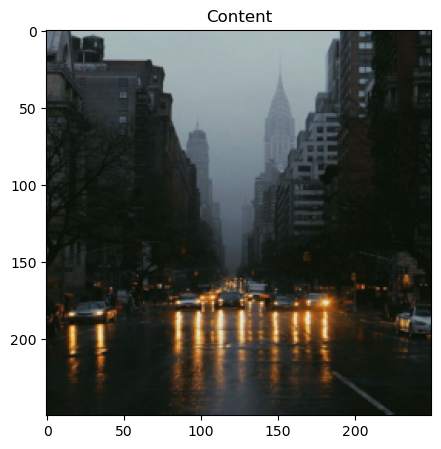

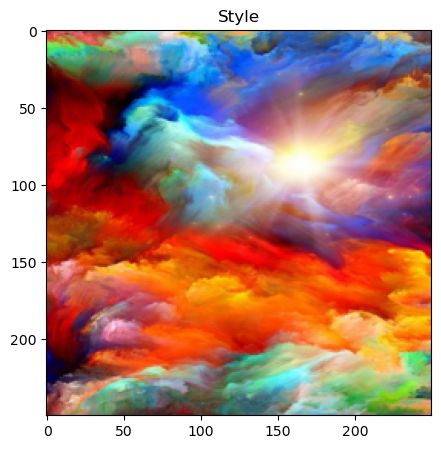

In [81]:
#функція завантаження зображення,зміни розміру та перетворення в тензор PyTorch, виведення цього зображення
def Load_images(path,title):
    image = Image.open(path)
    loader = transforms.Compose([transforms.Resize(size = (250, 250)),transforms.ToTensor()])
    tensor_image = loader(image).unsqueeze(0)
    image = tensor_image.clone().detach()
    image = image.squeeze(0)
    image = image.mul(255).byte()
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize = (5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.show()
    return tensor_image
    
content_image = Load_images('D:\KPI Styding\DataAnalysis\content.jpg',"Content")
style_image = Load_images('D:\\KPI Styding\\DataAnalysis\\style.jpg',"Style") 
    

In [82]:
#Завантажимо попередньонавчену модель vgg та заборонимо оновлення її параметрів
vgg = models.vgg19(pretrained = True).features
for param in vgg.parameters():
    param.requires_grad_(False)

# для проведення стилізації vgg буде використовувати центральний процесор
device = torch.device("cpu")
print(vgg.to(device)) 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [83]:
#Функція отримання ознак зображення з різних шарів моделі
def Get_features(tensor_image, model):
    layers = {"0": "conv1_1", "5": "conv2_1",
              "10": "conv3_1", "19": "conv4_1",
              "21": "conv4_2", "28": "conv5_1"}
    x = tensor_image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)  
        if name in layers:
            features[layers[name]] = x
    return features

content_features = Get_features(content_image, vgg)
style_features = Get_features(style_image, vgg)

In [77]:
#функція для обчислення Gram-матриці тензору
def Gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

#створимо словник назва шару->gram-матриця
grams_list = {layer: Gram_matrix(style_features[layer]) for layer in style_features}
#створимо копію тензора content
result_image = content_image.clone().requires_grad_(True).to(device)

# задамо ваги для кожного шару
style_weights = {"conv1_1": 1,"conv2_1": 0.75,
                 "conv3_1": 0.2, "conv4_1": 0.2,
                 "conv5_1": 0.2}
content_weight = 1
style_weight = 1000

In [84]:
iterations = 70
optimizer = optim.Adam([result_image], lr = 0.003) #будемо використовувавти оптимізатор Adam
for i in range(1, iterations + 1):
    result_features = get_features(result_image, vgg)
    # розрахунок середнього квадратичного відхилення 
    content_loss = torch.mean((result_features["conv4_2"] - content_features["conv4_2"]) ** 2)
    style_loss = 0
    #розрахунок втрат
    for layer in style_weights:
        result_feature = result_features[layer]
        _, d, h, w = result_feature.shape
        result_gram = Gram_matrix(result_feature)
        style_gram = grams_list[layer]
        layer_style_loss = torch.mean((result_gram - style_gram) ** 2)
        layer_style_loss *= style_weights[layer]
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad() 
    total_loss.backward() 
    optimizer.step()


In [85]:
def Show_tenzor_image(tenzor_image,title):
    image = tenzor_image.clone().detach()
    image = image.squeeze(0)
    image = image.mul(255).byte()
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize = (5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.show()

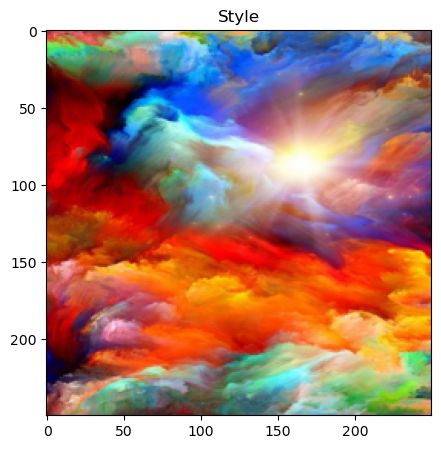

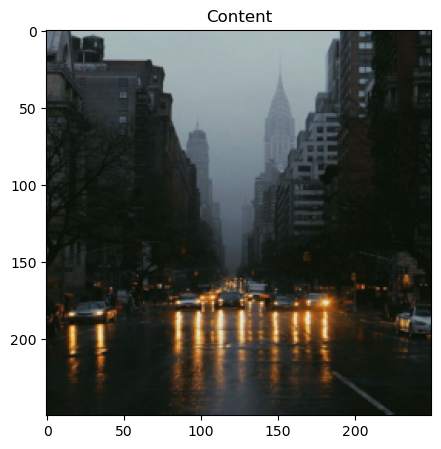

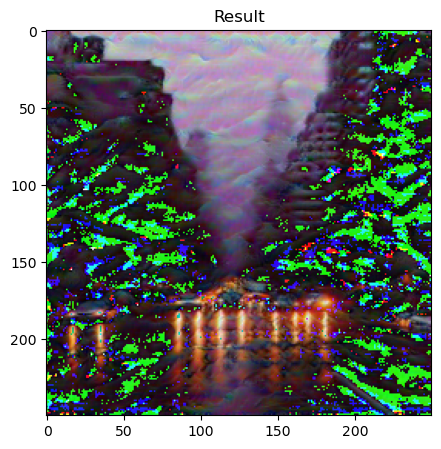

In [86]:
Show_tenzor_image(style_image,"Style")
Show_tenzor_image(content_image,"Content")
Show_tenzor_image(result_image,"Result")